This demo shows how to find objects in an image using template matching.

The main idea is to check the similarity between a search target(template) and a subsection of the image. The subsection is usually the same size as the template. Therefore by using `mapwindow` we can assign a value for every subsection of the image.

At first we import the following packages.

In [1]:
using ImageCore: Gray
using ImageMorphology: label_components, component_centroids
using ImageFiltering: mapwindow, Fill, imfilter, KernelFactors
using ImageDistances: sqeuclidean
using ImageContrastAdjustment: adjust_histogram, LinearStretching
using TestImages
using Plots: scatter!, plot

`ImageCore` enables the generation of images, `ImageFiltering` provides the `mapwindow` function and `ImageFeatures` provides functions to label segments of an image. To calculate the similarity `squeclidean` is used. This defines a distance between two images as:

$$
\textrm{distance} = \sum_i^{\textrm{number of pixels}} (\textrm{template}_i - \textrm{subsection}_i)^2
$$

`ImageContrastAdjustment` provides functions to adjust the histogram, which is useful when an image contains values bigger than 1 or smaller than 0.  The `Testimages` package will provide our image and plot is used to overlay a scatter plot onto the image.

To start we first load our image.

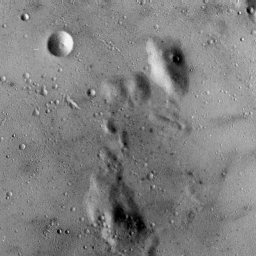

In [2]:
img = testimage("moonsurface")

Let's say we want to find the medium sized craters in the image based one of the impact areas. For this we generate a template from a subsection of the image and apply a small gaussian blur using `imfilter`. The gaussian blur often helps when the search targets are not exactly the same.

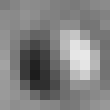

In [3]:
template = img[12:22,20:30]
template = imfilter(template,KernelFactors.gaussian((0.5,0.5)))

Now that we have an image and a template, the next step is to define how we measure the similarity between a section of the image and the template. This can be done in multiple way, but a sum of square distances should work quite well. The `ImageDistance` package provides an already optimized version called `sqeuclidean`, which can be used to define a function for `mapwindow`.  Let's call it `SDIFF`.

In [4]:
function SDIFF(template)
  (subsection)->sqeuclidean(subsection, template)
end

SDIFF (generic function with 1 method)

To actually generate our similarity map we use `mapwindow` in the following way.

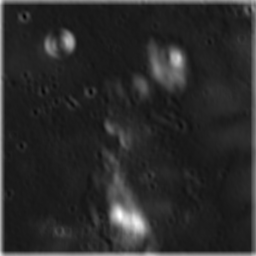

In [5]:
res = mapwindow(SDIFF(template), img, size(template), border=Fill(1)) .|> Gray
rescaled_map = adjust_histogram(res, LinearStretching())

If the subsection is located at the border of the image the image has to be extended and in our case we will fill all values outside the image with 1. One thing to keep in mind is that because all of the square differences will be summed up per subsection the resulting sum can be bigger than 1. This will be a problem if we just convert it to an image to check the values. To rescale the values to be between 0 and 1 we can use `adjust_histogram`.

To find the best locations we have to look for small values on the similarity map. This can be done by comparing if the pixel is below a certain value. Let's chose a value of `0.05`.

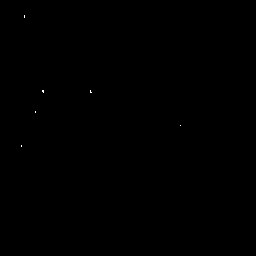

In [6]:
threshold = rescaled_map .< 0.05
Gray.(threshold)

Now we see small blobs at the locations which match our template and we can label the connected regions by `label_components`.  This will enumerate are connected regions and `component_centroids` can be used to get the centroid of each region.  `component_centroids` also return the centroid for the background region, which is at the first position and we will omit it.

In [7]:
centroids = component_centroids(label_components(threshold))[2:end]

6-element Vector{Tuple{Float64, Float64}}:
 (146.5, 22.0)
 (17.0, 25.0)
 (112.5, 36.0)
 (91.8, 43.6)
 (92.25, 91.25)
 (126.0, 181.0)

To check if it worked correctly we can overlay the centroids with the original image using the `Plots` package. As the images are stored using the first index for rows we have to reverse the order of the coordinates to match the order of the plotting library.

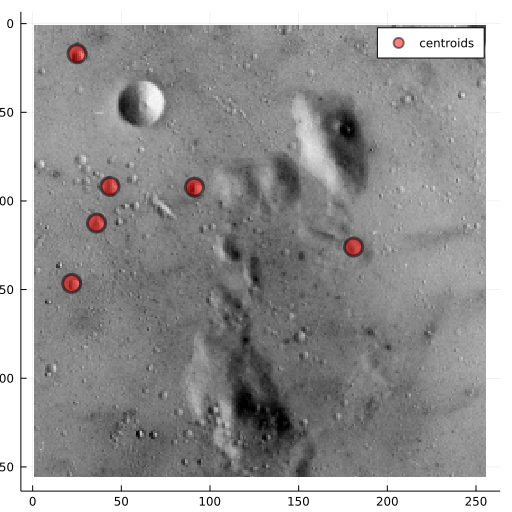

In [8]:
plot(Gray.(img), size=(512,512))
scatter!(reverse.(centroids), label="centroids", ms=10, alpha=0.5, c=:red, msw=3)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*